In [2]:
#https://github.com/hirokatsukataoka16/FractalDB-Pretrained-ResNet-PyTorch/blob/main/finetuning/main.py

#https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

# -*- coding: utf-8 -*-
"""
Created on Sat Aug 05 23:55:12 2018
@author: Kazushige Okayasu, Hirokatsu Kataoka
"""
import datetime
import time
import random
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torchvision import transforms

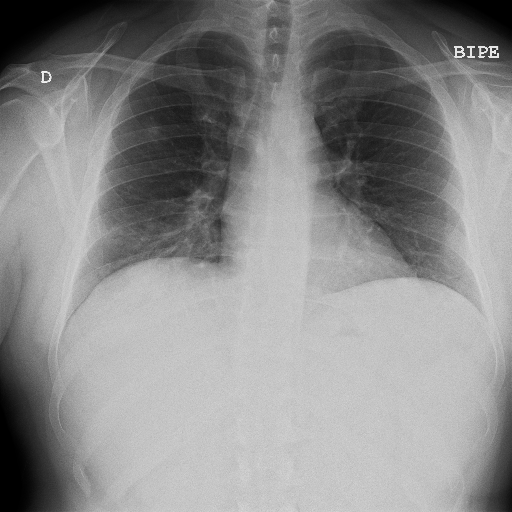

(512, 512, 3) 0 255
(512, 512, 3) 8.25063288454728e-05 1.0


In [21]:
from PIL import Image
import numpy as np
im = Image.open('/home/jovyan/COVID/DATA/TRAIN_TEST/TRAIN_DATASET_IMAGE/train/covid/MV01002818145801.png')      # imagen en color
im.show()
im = np.asarray(im)
print(im.shape, np.min(im), np.max(im))

im_npy = np.load('/home/jovyan/COVID/DATA/TRAIN_TEST/TRAIN_DATASET_NPY/train/covid/MV01002818145801.npy')
print(im_npy.shape, np.min(im_npy), np.max(im_npy))

In [3]:
import glob,os
import numpy as np

import torch
from PIL import Image

from torch.utils.data import Dataset

class DBLoader(Dataset):

	def __init__(self, root, phase, transform=None):
		self.transform = transform
		self.image_paths = []
		self.image_labels = []
		class_name = os.listdir(os.path.join(root, phase))
		class_name.sort()

		for (i,x) in enumerate(class_name):
			temp = glob.glob(os.path.join(root, phase, x, "*"))
			temp.sort()
			self.image_labels.extend([i]*len(temp))
			self.image_paths.extend(temp)
            
	def __getitem__(self, index):
		image_path = self.image_paths[index]
		image = Image.open(image_path)
#		print('ORIGINAL', np.array(image))
		#image=np.load(image_path,allow_pickle=True)
		if self.transform is not None:
			image = self.transform(image)
#			print('TENSOR',np.array(image))
		#print(image_path)
		#print(self.image_labels[index])
		return {"image":image,"label":self.image_labels[index]}
    
	def __len__(self):
		return len(self.image_paths)


In [16]:
import sys
import numpy as np

import torch
import torch.nn as nn

# Training
def train(log_interval, model, device, train_loader, optimizer, epoch, iteration):
	model.train()
	criterion = nn.CrossEntropyLoss(size_average=True) # previous PyTorch ver.
#	criterion = nn.BCELoss()
	for i_batch, sample_batched in enumerate(train_loader):
		data, target = sample_batched["image"].to(device), sample_batched["label"].to(device)
		#print(data, target)
		optimizer.zero_grad()
		output = model(data)
		pred = output.max(1, keepdim=True)[1]
		correct = pred.eq(target.view_as(pred)).sum().item()
#		target = target.unsqueeze(1)
#		target = target.float()
		loss = criterion(output, target)
		loss.backward()
		optimizer.step()
		if i_batch % log_interval == 0:
			sys.stdout.write("\rEpoch:{0:>3} iteration:{1:>6} Train: Train_Accuracy: {2:5.2f}  -  Train_Loss: {3:.6f} ".format(epoch, iteration, 100.*correct/float(len(sample_batched["label"])), loss.item()))
			sys.stdout.flush()
		iteration += 1
	list_trainloss=loss.item()
	#print(list_trainloss)
	list_trainacc=100.*correct/float(len(sample_batched["label"]))
	#print(list_trainacc)
    
	return list_trainloss, list_trainacc

# Validation
def val(model, device, test_loader, iteration):
	model.eval()
	criterion = nn.CrossEntropyLoss(size_average=False) # previous PyTorch ver. 
#	criterion = nn.BCELoss()
	test_loss = 0
	correct = 0
	with torch.no_grad():
		for i_batch, sample_batched in enumerate(test_loader):
			data, target = sample_batched["image"].to(device), sample_batched["label"].to(device)
			output = model(data)
#			target = target.unsqueeze(1)
#			target = target.float()
			test_loss += criterion(output, target).item()
			pred = output.max(1, keepdim=True)[1]
			correct += pred.eq(target.view_as(pred)).sum().item()
	test_loss /= float(len(test_loader.dataset))
	correct /= float(len(test_loader.dataset))
	print("\nValidation: Accuracy: {0:.2f}%  Val_Loss: {1:.6f}".format(100. * correct, test_loss))
	return test_loss, 100. * correct

In [47]:
import os
import sys

import torch
import torch.nn as nn
from torchvision import models

def model_select(path2weight, dataset, usenet, useepoch, numof_classes, numof_pretrained_classes, tweight):

    MODEL_ROOT = path2weight
    last_layer = nn.Linear(2048, numof_classes)
    
    if tweight=="fractals":
        # ResNet-50
        if usenet == "resnet50":
            #last_layer = nn.Linear(2048, numof_classes)
            model = models.resnet50(pretrained=False, num_classes=numof_pretrained_classes)
            #weight_name = os.path.join(path2weight, dataset + "_" + usenet + "_epoch" + str(useepoch) + ".pth")

            weight_name = os.path.join(path2weight, 'FractalDB-1000_resnet50_epoch90.pth')
            # FractalDB pre-trained model
            if os.path.exists(weight_name):
                print ("use pretrained model : %s" % weight_name)
                param = torch.load(weight_name)
                model.load_state_dict(param)
            
            
    elif tweight=="imagenet":
        print ("use pretrained model : IMAGEnet")
        model = models.resnet50(pretrained=True, num_classes=numof_pretrained_classes)
        #model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        
    model.fc = last_layer
    
    return model

In [80]:
# model name
datatrain="FUJI_HUMV" #siempre se entrena con este
datatest='FUJI_HSLL'

tweight="fractals" #imagenet or fractals
print('Transfer learning', tweight)

dataset='FractalDB-1000'
ft_dataset="COVID"

path2db="/home/jovyan/COVID/DATA/TRAIN_TEST/TRAIN_DATASET_IMAGE/" #FUJI_HUMV
print(path2db)

path2weight="/home/jovyan/COVID/PRETRAINED_MODEL_FRACTALS/"
path2savemodel="/home/jovyan/COVID/RESULTADOS/RESNET/MODELS/"
resume=''

usenet="resnet50"
useepoch=3
pretrain=False
epochs=10 #10 fractales
numof_pretrained_classes=1000
numof_classes=2
numof_fclayer=10 
last_epoch=1

lr=[0.00008] #0.0001 fractales ,0.001,0.0005,0.0001
momentum=0.9
weight_decay=1e-04
topt=["SGD"] #SGD fractales --> ,"Adam", "Adadelta", "RMS" , "Adadelta", "Adam", "Adagrad"

start_epoch=1
batch_size=[2]
test_batch_size=2
img_size=512
multigpu=False
no_cuda=True
gpu_id=-1
num_workers=4
save_interval=3
log_interval=10
seed=1

Transfer learning fractals
/home/jovyan/COVID/DATA/TRAIN_TEST/TRAIN_DATASET_IMAGE/


In [81]:

def plot_learning_curves(list_iteration, list_trainloss, list_trainacc, list_valloss,list_valacc, name_model, folder_to_save='/srv/resultados/curvas/'):
    '''
    This functions allows saving the learning curves performed during the training stage enclosed in H
    '''

    # Save curves training
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(list_iteration,list_trainacc)
    plt.plot(list_iteration,list_valacc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig(folder_to_save + 'Accuracy_' + name_model + '.png')

    plt.figure()
    plt.plot(list_iteration,list_trainloss)
    plt.plot(list_iteration,list_valloss)
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.savefig(folder_to_save + '/Loss_' + name_model + '.png')

def get_optimizer(topt,params, lr, weight_decay, momentum):
    if topt=="SGD":
        optimizer = optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif topt=="Adam":
        optimizer = optim.Adam(params, lr=lr, weight_decay=weight_decay)
    elif topt=="Adadelta":
        optimizer = optim.Adadelta(params, lr=lr, weight_decay=weight_decay)
    elif topt=="Adagrad":
        optimizer = optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    elif topt=="RMS":
        optimizer=optim.RMSprop(params, lr=lr, weight_decay=weight_decay) 
    return optimizer

In [82]:
def worker_init_fn(worker_id):
    random.seed(worker_id+seed)
    
def load_data(ibatch,test_batch_size,img_size,path2db,seed,worker_init_fn,num_workers):
    

                #to deterministic
    cudnn.deterministic = True
    random.seed(seed)
    torch.manual_seed(seed)

    # Training settings
    train_transform = transforms.Compose([
                                    transforms.Resize(img_size, interpolation=2),
                                    transforms.ToTensor()])

    train_fractal = DBLoader(path2db,'train',train_transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_fractal, batch_size=ibatch,
                                                        shuffle=True, 
                                                        pin_memory=True, drop_last=True, worker_init_fn=worker_init_fn,num_workers=num_workers) #

                # Validation settings
    test_transform = transforms.Compose([
                                    transforms.Resize(img_size, interpolation=2),
                                    transforms.ToTensor()])

    test_fractal = DBLoader(path2db,'test',test_transform)

    test_loader = torch.utils.data.DataLoader(dataset=test_fractal, batch_size=test_batch_size,
                                                        shuffle=True, pin_memory=True, drop_last=False, worker_init_fn=worker_init_fn, num_workers=num_workers*2) #num_workers=num_workers*2,
    return train_loader, test_loader

In [ ]:
import pandas as pd
from sklearn import metrics
from tensorflow.keras.utils import to_categorical

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Model & optimizer
for itopt in topt:
    for ilr in lr:
        for ibatch in batch_size:
            list_epoch, list_trainloss, list_trainacc, list_valloss, list_valacc = [], [], [], [], []

            name_model='MODEL_'+usenet+'_tweight'+tweight+'_lr'+str(ilr)+'_bach'+str(ibatch)+'_epoch'+str(epochs)+'_imgsize'+str(img_size)+'_train'+datatrain+'_opt'+itopt
            
            train_loader, test_loader = load_data(ibatch,test_batch_size,img_size,path2db,seed,worker_init_fn,num_workers)
            model = model_select(path2weight, dataset, usenet, useepoch, numof_classes, numof_pretrained_classes, tweight).to(device)
            
            params = list(model.parameters())
            optimizer = get_optimizer(itopt,params, ilr, weight_decay, momentum)

            '''if args.multigpu:
                #model = nn.DataParallel(model)
                optimizer = optim.SGD(params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
            else:
                optimizer = optim.SGD(params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
            '''
            scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)
            
            
            
            
            
            starttime = time.time()
            iteration = 0
            # optionally resume from a checkpoint
            if resume:
                assert os.path.isfile(resume), "=> no checkpoint found at '{}'".format(resume)
                print("=> loading checkpoint '{}'".format(resume))
                checkpoint = torch.load(resume, map_location=lambda storage, loc: storage)
                start_epoch = checkpoint['epoch']
                model.load_state_dict(checkpoint['state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer'])
                scheduler.load_state_dict(checkpoint['scheduler'])
                print("=> loaded checkpoint '{}' (epoch {})".format(resume, checkpoint['epoch']))
            if multigpu:
                model = nn.DataParallel(model)
            iteration = (start_epoch-1)*len(train_loader)

            # Training & Validation
            for epoch in range(1, epochs + 1):
                #print("\nepoch {}".format(epoch))
                trainloss, trainacc=train(log_interval, model, device, train_loader, optimizer, epoch, iteration)
                scheduler.step()
                iteration += len(train_loader)
                validation_loss, validation_accuracy = val(model, device, test_loader, iteration)

                list_epoch.append(epoch)
                list_valloss.append(validation_loss)
                list_valacc.append(validation_accuracy)
                list_trainloss.append(trainloss)
                list_trainacc.append(trainacc)

                if epoch % save_interval == 0:
                    saved_weight = os.path.join(path2savemodel, name_model +".pth")
                    if multigpu:
                        torch.save(model.module.cpu().state_dict(), saved_weight)
                        model_state = model.module.cpu().state_dict()
                    else:
                        torch.save(model.cpu().state_dict(), saved_weight)
                        model_state = model.cpu().state_dict()

                    # Save checkpoint
                    checkpoint = "{}/{}_{}_checkpoint.pth.tar".format(path2savemodel, dataset, usenet)
                    torch.save({'epoch': epoch + 1,
                                'state_dict': model_state,
                                'optimizer' : optimizer.state_dict(),
                                'scheduler' : scheduler.state_dict(),}, checkpoint)
                    model = model.to(device)

                    
            plot_learning_curves(list_epoch, list_trainloss, list_trainacc, list_valloss, list_valacc, name_model, folder_to_save='/home/jovyan/COVID/RESULTADOS/RESNET/MODELS/')

            
            # Processing time
            endtime = time.time()
            interval = endtime - starttime
            print ("elapsed time = %dh %dm %ds" % (int(interval/3600),int((interval%3600)/60),int((interval%3600)%60)))

use pretrained model : /home/jovyan/COVID/PRETRAINED_MODEL_FRACTALS/FractalDB-1000_resnet50_epoch90.pth
Epoch:  1 iteration:   180 Train: Train_Accuracy: 100.00  -  Train_Loss: 0.387241 
Validation: Accuracy: 60.16%  Val_Loss: 0.677099
Epoch:  2 iteration:   370 Train: Train_Accuracy: 100.00  -  Train_Loss: 0.425092 
Validation: Accuracy: 64.84%  Val_Loss: 0.596826
Epoch:  3 iteration:   560 Train: Train_Accuracy: 100.00  -  Train_Loss: 0.369544 
Validation: Accuracy: 60.94%  Val_Loss: 0.638323
Epoch:  4 iteration:   750 Train: Train_Accuracy: 50.00  -  Train_Loss: 0.601602  
Validation: Accuracy: 68.75%  Val_Loss: 0.525281
Epoch:  5 iteration:   940 Train: Train_Accuracy: 50.00  -  Train_Loss: 0.711403  
Validation: Accuracy: 84.38%  Val_Loss: 0.437426
Epoch:  6 iteration:  1130 Train: Train_Accuracy: 100.00  -  Train_Loss: 0.486338 
Validation: Accuracy: 80.47%  Val_Loss: 0.456591
Epoch:  7 iteration:  1320 Train: Train_Accuracy: 100.00  -  Train_Loss: 0.292805 
Validation: Accuracy:

In [ ]:
def get_img_array_CAMS(img_path, size):
    # `img` is a PIL image of size 299x299
    from PIL import Image

    img=Image.open(img_path) 
    
    img = img.resize(size)
    array = np.array(img, dtype='f')
    #array=array/255
    
    #array = (array - np.min(array)) / (np.max(array) - np.min(array))
    
    #array=array.astype(float32)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    #array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    
    return array


def gradcam_h(img_array, model, last_conv_layer_name, threshold):
    img_array = np.expand_dims(img_array, axis=0)
    layerToPredict = model.get_layer(last_conv_layer_name)
    # Predict image
    predictions = model.predict(img_array)
    idx = np.argmax(predictions)

    # Outputs associated to the class of interest
    output_class = model.output[:, idx]

    # Gradients associated to the class of interest
    grads = K.gradients(output_class, layerToPredict.output)[0]

    # Mean of gradients
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    iterate = K.function([model.input], [pooled_grads, layerToPredict.output[0]])

    # Output of layer using the model with respect to the input
    pooled_grads_value, conv_layer_output_value = iterate([img_array])

    # Multiply each channel of the feature map by how the important is the channel regarding the objective class
    conv_layer_output_value = conv_layer_output_value
    for i in range(np.shape(pooled_grads_value)[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Generate the heat maps
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Apply threshold
    retval, heatmap = cv2.threshold(heatmap, threshold, 1, cv2.THRESH_BINARY)
    heatmap = cv2.resize(heatmap, (128,128))
    cm = plt.get_cmap('jet')

    # Colour
    colored_image = cm(heatmap)[:, :, :3]
    
    return colored_image

def CAMSVisualize(img_path, img_size, path_model, last_conv_layer_name, threshold):
    
    
    # Prepare image
    img_array = get_img_array_CAMS(img_path, size=img_size)
    #print(np.max(img_array))
    # Make model
    model = load_model(path_model)
    #model.summary()
    
    # Generate class activation heatmap
    heatmap = gradcam_h(img_array, model, last_conv_layer_name, threshold)

    img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
    cam_img = img_array * 0.8 + heatmap * 0.2

    # Save CAMs
    saveDir = '/srv/data/HIC/code/JPG_50_50/models Anna/testresults/cams/' 
    path = img_path.split('/')
    name_img=path[-1]
    
    if not os.path.exists(saveDir):
        os.mkdir(saveDir)
    save_img(saveDir+ name_img, cam_img)

    print('Saved ' + name_img)

    # Display heatmap
    plt.rcParams["axes.grid"] = False
    plt.matshow(heatmap)
    #plt.imsave(saveDir+name_img, cam_img) 
    plt.show()

In [70]:
from sklearn import metrics
from tabulate import tabulate

def report_classification_results(y_true, y_pred, classes, paths, name_model):
    
    # Extract confusion matrix
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # Compute metrics
    headers = []
    g_TP, g_TN, g_FN, g_FP = [], [], [], []
    ss, ee, pp, nn, ff, aa = [], [], [], [], [], []
    S, E, PPV, NPV, F, ACC = ['Sensitivity'], ['Specificity'], ['PPV (precision)'], ['NPV'], ['F1-score'], ['Accuracy']
    for i in range(len(classes)):
        headers.append(classes[str(i)])

        # Extract indicators per class
        TP = conf_mat[i, i]
        TN = sum(sum(conf_mat)) - sum(conf_mat[i, :]) - sum(conf_mat[:, i]) + TP
        FN = sum(conf_mat[i, :]) - conf_mat[i, i]
        FP = sum(conf_mat[:, i]) - conf_mat[i, i]

        # Extract metrics per class
        sen = TP/(TP + FN)
        spe = TN/(TN + FP)
        ppv = TP/(TP + FP)
        npv = TN/(TN + FN)
        f1_s = 2*ppv*sen/(ppv + sen)
        acc = (TP + TN)/(TP + TN + FP + FN)
        
        
        # Create table for printing
        S.append(str(round(sen, 4)))
        E.append(str(round(spe, 4)))
        PPV.append(str(round(ppv, 4)))
        NPV.append(str(round(npv, 4)))
        F.append(str(round(f1_s, 4)))
        ACC.append(str(round(acc, 4)))
        
        
        # Global indicators
        g_TP.append(TP), g_TN.append(TN), g_FP.append(FP), g_FN.append(FN)
        
        # Global metrics
        ss.append(sen), ee.append(spe), pp.append(ppv), nn.append(npv), ff.append(f1_s), aa.append(acc)
        
    # Extract micro values
    micro_S = round(sum(g_TP) / (sum(g_TP) + sum(g_FN)), 4)
    micro_E = round(sum(g_TN) / (sum(g_TN) + sum(g_FP)), 4)
    micro_PPV = round(sum(g_TP) / (sum(g_TP) + sum(g_FP)), 4)
    micro_NPV = round(sum(g_TN) / (sum(g_TN) + sum(g_FN)), 4)
    micro_F1 = round(2 * micro_S * micro_PPV / (micro_S + micro_PPV), 4)
    micro_Acc = round((sum(g_TP) + sum(g_TN)) / (sum(g_TP) + sum(g_TN) + sum(g_FP) + sum(g_FN)), 4)
    
    # Extract macro values
    macro_S = round(sum(ss) / len(ss), 4)
    macro_E = round(sum(ee) / len(ee), 4)
    macro_PPV = round(sum(pp) / len(pp), 4)
    macro_NPV = round(sum(nn) / len(nn), 4)
    macro_F1 = round(sum(ff) / len(ff), 4)
    macro_Acc = round(sum(aa) / len(aa), 4)

    
    # Construct the table
    S.append('---'), E.append('---'), PPV.append('---'), NPV.append('---'), F.append('---'), ACC.append('---')
    S.append(micro_S), E.append(micro_E), PPV.append(micro_PPV), NPV.append(micro_NPV), F.append(micro_F1), ACC.append(
          micro_Acc)
    S.append(macro_S), E.append(macro_E), PPV.append(macro_PPV), NPV.append(macro_NPV), F.append(macro_F1), ACC.append(
            macro_Acc)

    # Define table
    my_data = [tuple(S), tuple(E), tuple(PPV), tuple(NPV), tuple(F), tuple(ACC)]

    # MODEL metrics
    if len(classes) > 2:
        auc = metrics.roc_auc_score(y_true=to_categorical(y_true, num_classes=len(classes)),
                                        y_score=to_categorical(y_pred, num_classes=len(classes)), multi_class='ovr')
    else:
        auc = metrics.roc_auc_score(y_true=y_true, y_score=y_pred)
        
    # Printing results
    headers.append('-'), headers.append('micro-Avg'), headers.append('macro-Avg'), headers.append('AUC')
    print(tabulate(my_data, headers=headers))
    print('------------------------\nAUC', round(auc, 4))

    df = pd.DataFrame(my_data)
    df=df.assign(AUC=round(auc, 4))
    df.to_csv(paths +name_model+'_AUC_'+str(round(auc, 4))+'.csv')

    return round(auc, 4)

#def plot_confusion_matrix(y_true, y_pred, numfold, classes,name_model, normalize=False, title=None, cmap=plt.cm.Blues, dir_out=''):

def plot_confusion_matrix(y_true, y_pred, classes, name_model, normalize=False, title=None, cmap=plt.cm.Blues, dir_out=''):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = [classes['0'], classes['1'], classes['2'], classes['3']]
    # classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    ax.figure.savefig(dir_out +'/'+name_model+'.png')
    plt.close()

    return ax


In [58]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import argparse
import cv2
import numpy as np
import torch
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image

# Loading the saved model
save_path = '/srv/pretrain/pretrain/MODEL_resnet50_lr0.0001_bach2_epoch10_imgsize512_trainvaldecilla_testLaredo.pth'
#last_layer = nn.Linear(2048, numof_classes)
model = models.resnet50(pretrained=False, num_classes=numof_pretrained_classes)
# FractalDB pre-trained model

#num_ftrs = model.fc.in_features
model.fc = nn.Linear(2048, numof_classes)  # make the change

if os.path.exists(save_path):
    #print ("use pretrained model : %s" % save_path)
    param = torch.load(save_path)
    model.load_state_dict(param)
target_layers = model.layer4[-1]
 
for dirpath, dirnames, fileList in os.walk('/srv/data/train_test_labels/test/'):
    dirnames=['COLUMNA CERVICAL AP', 'TORAX PA','TOBILLO AP','RODILLA AP']
    for direc in dirnames:
        dir_final=dirpath+direc+'/'
        for dirpath1, dirnames1, fileList1 in os.walk(dir_final):
            for name_img in fileList1:
                
                #rgb_img = cv2.imread('/srv/data/train_test_labels/test/'+direc+'/'+str(file)+'.jpg', 1)[:, :, ::-1]
                rgb_img = cv2.imread(dir_final+name_img, 1)[:, :, ::-1]

                rgb_img = cv2.resize(rgb_img, (128, 128))
                #rgb_img = np.float32(rgb_img) / 255
                rgb_img = np.float32(rgb_img) 

                input_tensor = preprocess_image(rgb_img)# Create an input tensor image for your model..
                # Note: input_tensor can be a batch tensor with several images!

                # Construct the CAM object once, and then re-use it on many images:
                cam = GradCAM(model=model, target_layer=target_layers, use_cuda=True)
                #print(cam)

                    # You can also use it within a with statement, to make sure it is freed,
                    # In case you need to re-create it inside an outer loop:
                    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
                    #   ...

                    # If target_category is None, the highest scoring category
                    # will be used for every image in the batch.
                    # target_category can also be an integer, or a list of different integers
                    # for every image in the batch.
                if direc =='ABDOMEN SIMPLE AP':
                    target_category=0
                elif direc =='COLUMNA CERVICAL AP':
                    target_category=1
                elif direc =='COLUMNA CERVICAL LAT':
                    target_category=2
                elif direc == 'PIE AP':
                    target_category=3
                elif direc =='PIE OBLICUA':
                    target_category=4
                elif direc =='RODILLA AP':
                    target_category=5                
                elif direc == 'RODILLA LAT':
                    target_category=6
                elif direc =='TOBILLO AP':
                    target_category=7
                elif direc == 'TOBILLO LAT':
                    target_category=8
                elif direc == 'TORAX LAT': 
                    target_category=9
                elif direc =='TORAX PA':
                    target_category=10

                    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
                grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

                    # In this example grayscale_cam has only one image in the batch:
                grayscale_cam = grayscale_cam[0,:,:]
                
                rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
                
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                plt.rcParams["axes.grid"] = False

                plt.imshow(visualization)
                plt.savefig('/srv/resultados/metrics/cam/cam_'+direc+'_'+name_img) 

ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [75]:
import pandas as pd
from sklearn import metrics
from tensorflow.keras.utils import to_categorical

# Disable grad
with torch.no_grad():
    
    
    ind = 0
    paths=[]

    # Loading the saved model
    save_path = '/home/jovyan/COVID/RESULTADOS/RESNET/MODELS/'
    
    name_model='MODEL_resnet50_tweightfractals_lr0.0001_bach2_epoch10_imgsize512_trainFUJI_HUMV_optSGD'
    namodel=name_model+'.pth'
    
    
    print('[INFO] MODELO UTILIZADO: ',namodel)
    model = models.resnet50(pretrained=False, num_classes=numof_pretrained_classes)

    # FractalDB pre-trained model
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(2048, numof_classes)  # make the change

    if os.path.exists(save_path):
        #print ("use pretrained model : %s" % save_path)
        param = torch.load(save_path+namodel)
        model.load_state_dict(param)
        #print(model)
    
    for testdata in ['FUJI_HUMV','FUJI_HSLL', 'GE_HSLL', 'CARESTREAM_HSLL']:
        predict_list=[]
        true_target_list=[]
        
        for direc in ['covid','control']:
            for dirpath, dirnames1, fileList1 in os.walk('/home/jovyan/COVID/DATA/PNG_NPY_PABLO/'+testdata+'/'+direc+'/'):

                if direc =='control':
                    true_target=0
                elif direc =='covid':
                    true_target=1

                for ifile in fileList1:
                    image = Image.open(dirpath+'/'+ifile)

                    image_t = transforms.ToTensor()(image).unsqueeze_(0)
                    model.eval()

                    # Generate prediction
                    prediction = model(image_t)

                    # Predicted class value using argmax
                    predicted_class = np.argmax(prediction)

                    predict_list.append(predicted_class)
                    true_target_list.append(true_target)

                    #a.append()

                    '''if predicted_class != true_target:    
                        classes={'0':'CONTROL','1':'COVID'}
                        print(classes)
                        # Show result
                        folderandfile=direc+'_and_'+ifile
                        plt.imshow(image, cmap='gray')
                        plt.title(f'Prediction: {predicted_class} - Actual target: {true_target} - Folder & file: {folderandfile}')
                        plt.savefig("/home/jovyan/COVID/RESULTADOS/RESNET/ERRORES/"+testdata+"/"+folderandfile+".jpg")
                        plt.show()'''

        classes={'0':'CONTROL','1':'COVID'}
        report_classification_results(true_target_list, predict_list, classes, '/home/jovyan/COVID/RESULTADOS/RESNET/METRICS/', name_model + '_testdata_'+testdata)

[INFO] MODELO UTILIZADO:  MODEL_resnet50_tweightfractals_lr0.0001_bach2_epoch10_imgsize512_trainFUJI_HUMV_optSGD.pth
CONTROL            COVID       -  micro-Avg      macro-Avg     AUC
---------------  -------  ------  -----------  -----------  ------
Sensitivity       0.9551  0.9272  ---                0.944  0.9412
Specificity       0.9272  0.9551  ---                0.944  0.9412
PPV (precision)   0.9521  0.9317  ---                0.944  0.9419
NPV               0.9317  0.9521  ---                0.944  0.9419
F1-score          0.9536  0.9294  ---                0.944  0.9415
Accuracy          0.944   0.944   ---                0.944  0.944
------------------------
AUC 0.9412
CONTROL            COVID       -  micro-Avg      macro-Avg     AUC
---------------  -------  ------  -----------  -----------  ------
Sensitivity       0.8412  0.6066  ---               0.7606  0.7239
Specificity       0.6066  0.8412  ---               0.7606  0.7239
PPV (precision)   0.8033  0.6667  ---       

In [67]:
classes={'0':'CONTROL','1':'COVID'}
report_classification_results(true_target_list, predict_list, classes, '/home/jovyan/COVID/RESULTADOS/RESNET/METRICS/', name_model)

CONTROL            COVID       -  micro-Avg      macro-Avg     AUC
---------------  -------  ------  -----------  -----------  ------
Sensitivity       0.8412  0.6066  ---               0.7606  0.7239
Specificity       0.6066  0.8412  ---               0.7606  0.7239
PPV (precision)   0.8033  0.6667  ---               0.7606  0.735
NPV               0.6667  0.8033  ---               0.7606  0.735
F1-score          0.8218  0.6352  ---               0.7606  0.7285
Accuracy          0.7606  0.7606  ---               0.7606  0.7606
------------------------
AUC 0.7239


0.7239

In [56]:
report_classification_results(true_target_list, predict_list, classes, '/home/jovyan/COVID/RESULTADOS/RESNET/METRICS/', namodel)

NameError: name 'confusion_matrix' is not defined

In [ ]:
if predicted_class is '0':
                            predicted_class_title='ABDOMENT SIMPLE AP'
                        elif predicted_class is '1':
                            predicted_class_title='COLUMNA CERVICAL AP'
                        elif predicted_class is '2':
                            predicted_class_title='COLUMNA CERVICAL LAT'
                        elif predicted_class is '3':
                            predicted_class_title='PIE AP'
                        elif predicted_class is '4':
                            predicted_class_title='PIE OBLICUA'
                        elif predicted_class is '5':
                            predicted_class_title='RODILLA AP'
                        elif predicted_class is '6':
                            predicted_class_title='RODILLA LAT'
                        elif predicted_class is '7':
                            predicted_class_title='TOBILLO AP'
                        elif predicted_class is '8':
                            predicted_class_title='TOBILLO LAT'
                        elif predicted_class is '9':
                            predicted_class_title='TORAX LAT'
                        elif predicted_class is '10':
                            predicted_class_title='TORAX PA'
                            
                        if true_target is 0:
                            true_target_title='ABDOMENT SIMPLE AP'
                        elif true_target is 1:
                            true_target_title='COLUMNA CERVICAL AP'
                        elif true_target is 2:
                            true_target_title='COLUMNA CERVICAL LAT'
                        elif true_target is 3:
                            true_target_title='PIE AP'
                        elif true_target is 4:
                            true_target_title='PIE OBLICUA'
                        elif true_target is 5:
                            true_target_title='RODILLA AP'
                        elif true_target is 6:
                            true_target_title='RODILLA LAT'
                        elif true_target is 7:
                            true_target_title='TOBILLO AP'
                        elif true_target is 8:
                            true_target_title='TOBILLO LAT'
                        elif true_target is 9:
                            true_target_title='TORAX LAT'
                        elif true_target is 10:
                            true_target_title='TORAX PA'

In [124]:
cantidad=0
cantidad_direc=0
for dirpath, dirnames, fileList in os.walk('/srv/data/train_test_labels/test/'):
    for direc in dirnames:
        for dirpath, dirnames, fileList1 in os.walk('/srv/data/train_test_labels/test/'+direc+'/'):
            print(direc)
            cantidad_direc=cantidad_direc+1
            for ifile in fileList1:
                cantidad=cantidad+1

print(cantidad_direc)
print(cantidad)

PIE AP
TOBILLO AP
RODILLA AP
TOBILLO LAT
COLUMNA CERVICAL AP
PIE OBLICUA
TORAX LAT
ABDOMEN SIMPLE AP
TORAX PA
RODILLA LAT
COLUMNA CERVICAL LAT
11
499


In [1]:
!nvidia-smi

Mon Oct 11 14:13:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  